In [12]:
from datetime import datetime
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import PIL
import numpy as np

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [13]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print('n_samples: {ns}'.format(ns=n_samples))
print('n_features: {nf}'.format(nf=n_features))
print('n_classes: {}'.format(n_classes))

2017-03-17 07:27:41,003 Loading LFW people faces from /Users/Mike/scikit_learn_data/lfw_home


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [14]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=np.random.RandomState())

In [15]:
n_components = 150

print("Extracting the top {nc} eigenfaces from {nf} faces".format(nc=n_components, nf=X_train.shape[0]))
start = datetime.now()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("done in {dur:.3f}s".format(dur=(datetime.now() - start).total_seconds()))

eigenfaces = pca.components_.reshape((n_components, h, w))

print('Projecting the input data on the eigenfaces orthonormal basis')
start = datetime.now()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in {dur:.3f}s".format(dur=(datetime.now() - start).total_seconds()))

Extracting the top 150 eigenfaces from 966 faces
done in 0.519s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.040s


In [16]:
print('Fitting the classifier to the training set')
start = datetime.now()
param_grid = {'hidden_layer_sizes': [(500,), (750,), (1000,), (750, 1000, 500)],
              'solver': ['lbfgs', 'adam'],
              'alpha': [.00001, .0001]}
clf = GridSearchCV(MLPClassifier(), param_grid)
clf = clf.fit(X_train_pca, y_train)
print('done in {dur:.3f}s'.format(dur=(datetime.now() - start).total_seconds()))
print('Best estimator found by grid search:')
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 125.738s
Best estimator found by grid search:
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(750,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


In [17]:
print("Predicting people's names on the test set")
start = datetime.now()
y_pred = clf.predict(X_test_pca)
print("done in {dur:.3f}s".format(dur=(datetime.now() - start).total_seconds()))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.006s

Accuracy: 0.84
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.71      0.79        21
     Colin Powell       0.87      0.87      0.87        62
  Donald Rumsfeld       0.88      0.80      0.84        35
    George W Bush       0.86      0.93      0.90       133
Gerhard Schroeder       0.75      0.60      0.67        25
      Hugo Chavez       0.71      0.67      0.69        15
       Tony Blair       0.79      0.84      0.81        31

      avg / total       0.84      0.84      0.84       322

[[ 15   1   0   3   1   0   1]
 [  1  54   0   6   0   1   0]
 [  0   0  28   4   1   1   1]
 [  0   3   4 124   0   1   1]
 [  0   2   0   4  15   1   3]
 [  1   1   0   1   1  10   1]
 [  0   1   0   2   2   0  26]]


In [18]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    plt.style.use('seaborn-dark')
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


def title(y_pred, y_test, target_names, i):
    """Helper function to extract the prediction titles"""
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: {p}\ntrue:      {t}'.format(p=pred_name, t=true_name)

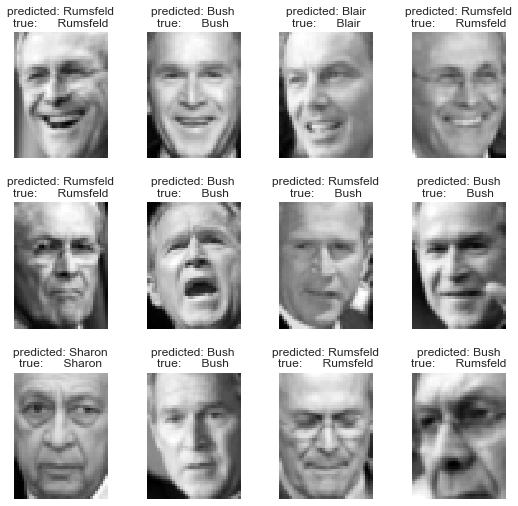

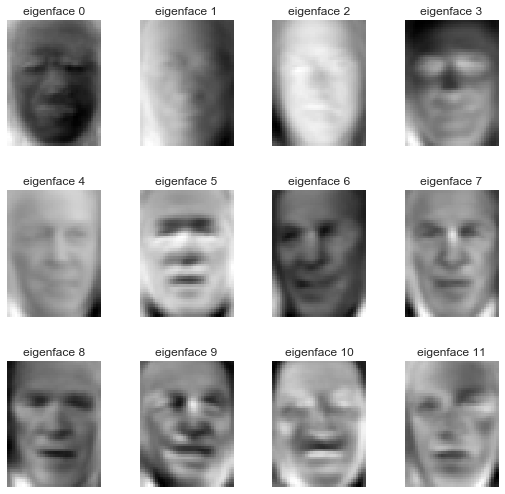

In [19]:
prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface {}".format(i) for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()